In [5]:
import pandas as pd
from ast import literal_eval
import numpy as np
np.seterr(all="raise")

today = "2019-11-06"

df = pd.read_parquet(f"out/{today}-1d-test.parquet")
df["total_params1"] = df["shape1[0]"]# * df["shape1[1]"]
df["total_params2"] = df["shape2[0]"]# * df["shape2[1]"]
print(len(df))
df.tail()

60000


,shape1[0],shape2[0],mode,seed,fft_time,direct_time,total_params1,total_params2
59995,45,949,full,19998,0.000166,0.000067,45,949
59996,45,949,same,19998,0.000179,0.000518,45,949
59997,23489,45440,valid,19999,0.003046,0.099871,23489,45440
59998,23489,45440,full,19999,0.002872,0.213914,23489,45440
59999,23489,45440,same,19999,0.002797,13.728895,23489,45440


In [6]:
from functools import lru_cache

def _prod(iterable):
    r = 1
    for it in iterable:
        r *= it
    return r
    
sum_builtin = sum

# def _get_constant(mode, x_ndim, x_size, h_size):
#     if mode == 'full':
#         big_O_constant = 10963.92823819 if x_ndim == 1 else 8899.1104874
#     elif mode == 'same':
#         oneD_big_O = {True: 7183.41306773, False: 856.78174111}
#         big_O_constant = oneD_big_O[h_size <= x_size] if x_ndim == 1 \
#                                                       else 34519.21021589
#     elif mode == 'valid':
#         big_O_constant = 41954.28006344 if x_ndim == 1 else 66453.24316434
#     else:
#         raise ValueError('mode is invalid')
#     return big_O_constant

@lru_cache()
def _get_constant(mode, x_ndim, x_size, h_size):
    df = pd.read_csv("constants.csv")
    if mode != "same":
        idx = (df["ndim"] == 1) & (df["mode"] == mode)
    else: 
        cond = "smaller_kernel" if h_size <= x_size else "bigger_kernel"
        idx = (df["ndim"] == 1) & (df["mode"] == "same") & (df["cond"] == cond)
    assert idx.sum() == 1
    return df[idx]["constant"].values.item()

In [7]:
def _fftconv_faster(x_shape, h_shape, mode):
    """
    See if using fftconvolve or convolve is faster. The value returned (a
    boolean) depends on the sizes and shapes of the input values.
    The big O ratios were found to hold to different machines, which makes
    sense as it's the ratio that matters (the effective speed of the computer
    is found in both big O constants). Regardless, this had been tuned on an
    early 2015 MacBook Pro with 8GB RAM and an Intel i5 processor.
    """
    x_size = _prod(x_shape)
    x_ndim = len(x_shape)
    h_size = _prod(h_shape)
    h_ndim = len(h_shape)
    if mode == 'full':
        out_shape = [n + k - 1 for n, k in zip(x_shape, h_shape)]
    elif mode == 'same':
        out_shape = x_shape
    elif mode == 'valid':
        out_shape = [n - k + 1 for n, k in zip(x_shape, h_shape)]
    else:
        raise ValueError('mode is invalid')
    out_shape = [o if o > 0 else -o + 2 for o in out_shape]

    # see whether the Fourier transform convolution method or the direct
    # convolution method is faster (discussed in scikit-image PR #1792)
    direct_time = min(x_size, h_size) * _prod(out_shape)
    fft_time = sum_builtin(n * np.log(n) for n in (x_shape + h_shape +
                                               tuple(out_shape)))
    big_O_constant = _get_constant(mode, x_ndim, x_size, h_size)
    return "fft" if big_O_constant * fft_time < direct_time else "direct"

def estimate_faster_method(row):
    x_shape = (row["shape1[0]"], )#row["shape1[1]"])
    h_shape = (row["shape2[0]"], )#row["shape2[1]"])
    mode = row["mode"]
    return _fftconv_faster(x_shape, h_shape, mode)

In [8]:
fft_faster = df["fft_time"] < df["direct_time"]
df["faster"] = ""
df.loc[fft_faster, "faster"] = "fft"
df.loc[~fft_faster, "faster"] = "direct"

df["faster_est"] = df.apply(estimate_faster_method, axis=1)

df["correct"] = (df.faster == df.faster_est)
acc = df["correct"].sum() / len(df)
print(f"Predicted fastest method {100 * acc:0.2f}% of the time")

Predicted fastest method 86.61% of the time


**Goal for accuracy on predicting fastest**: >90% -- that's the performance seen with code from SciPy 1.3 (after uncommenting `_get_constant` function above)

In [9]:
idx = (df["mode"] == "same") & (df["shape1[0]"] < df["shape2[0]"])
df["cond"] = "a"
df.loc[idx, "cond"] = "bigger_kernel"
idx = (df["mode"] == "same") & (df["shape1[0]"] >= df["shape2[0]"])
df.loc[idx, "cond"] = "smaller_kernel"

In [10]:
show = df.pivot_table(
    columns="cond",
    index="mode",
    values="correct",
).reset_index()
show.melt(id_vars=["mode"]).dropna()

,mode,cond,value
0,full,a,0.907600
2,valid,a,0.922150
4,same,bigger_kernel,0.626936
7,same,smaller_kernel,0.908729


In [11]:
wrong_idx = df.faster != df.faster_est
wrong =  df[wrong_idx].copy()
wrong["ratio"] = wrong.fft_time / wrong.direct_time
idx = wrong.ratio < 1
wrong.loc[idx, "ratio"] = 1 / wrong.loc[idx, "ratio"]

vals = wrong.copy()
vals.sort_values(by="direct_time", inplace=True)
vals.tail(n=10)

,shape1[0],shape2[0],mode,seed,fft_time,direct_time,total_params1,total_params2,faster,faster_est,correct,cond,ratio
47420,241,86727,same,15806,0.003665,0.215939,241,86727,fft,direct,False,bigger_kernel,58.923622
7694,215,92835,same,2564,0.004353,0.217707,215,92835,fft,direct,False,bigger_kernel,50.009858
50120,227,96609,same,16706,0.004123,0.223633,227,96609,fft,direct,False,bigger_kernel,54.243812
16295,273,86846,same,5431,0.003377,0.238458,273,86846,fft,direct,False,bigger_kernel,70.603205
45350,269,88797,same,15116,0.003351,0.240062,269,88797,fft,direct,False,bigger_kernel,71.639417
26048,289,86966,same,8682,0.003364,0.247841,289,86966,fft,direct,False,bigger_kernel,73.677723
33569,291,86816,same,11189,0.003410,0.250473,291,86816,fft,direct,False,bigger_kernel,73.455461
3215,279,87002,same,1071,0.003729,0.254670,279,87002,fft,direct,False,bigger_kernel,68.288135
43469,277,96805,same,14489,0.003607,0.264006,277,96805,fft,direct,False,bigger_kernel,73.187178
13799,271,98930,same,4599,0.003543,0.269768,271,98930,fft,direct,False,bigger_kernel,76.143203


In [12]:
vals["correct"] = (vals["faster"] == vals["faster_est"])#.astype(float)
print(vals["faster"].unique())
print(vals["faster_est"].unique())
print(vals.correct.unique())

vals.pivot_table(
    index="mode",
    values="correct",
    aggfunc=np.mean,
)

['direct' 'fft']
['fft' 'direct']
[False]


,correct
mode,
full,False
same,False
valid,False


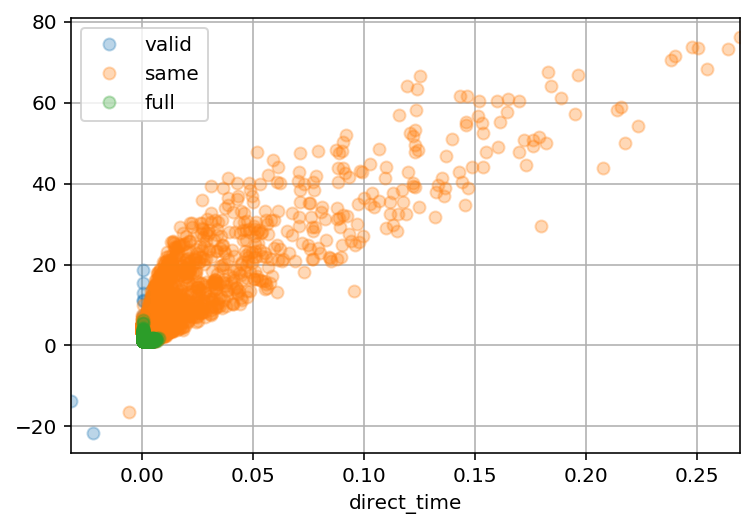

In [15]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
for mode in vals["mode"].unique():
    ax = vals[vals["mode"] == mode].plot(
        x="direct_time", y="ratio", style="o", alpha=0.3,
        ax=ax, label=mode,
    )
# ax.set_xscale("log")
# ax.set_yscale("log")
ax.legend()
ax.grid()
ax.grid(which="minor", alpha=0.2)

In [16]:
vals.ratio.max()

76.14320323014805

In [17]:
vals.direct_time.min()

-0.032315969467163086

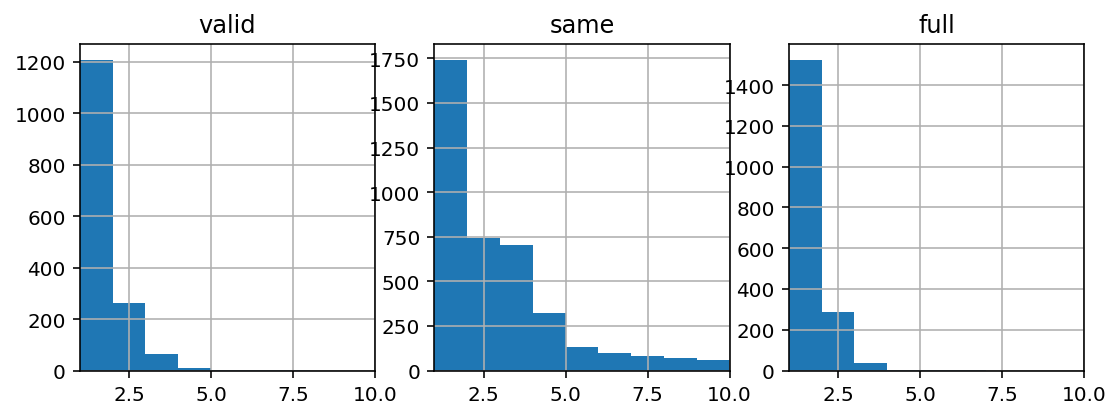

In [18]:
lims = range(int(wrong.ratio.max() + 1))

import matplotlib.pyplot as plt
w = 3
fig, axs = plt.subplots(ncols=3, figsize=(3*w, w))
for mode, ax in zip(["valid", "same", "full"], axs):
    show = wrong[wrong["mode"] == mode]
    ax = show.ratio.hist(bins=lims, ax=ax)
    _ = ax.set_xlim(1, 10)
    _ = ax.set_title(mode)
    _ = ax.set_xlim(1, 10)

**Goal for this histogram:** `ratio.max() < 5` approximately. That's the performance with SciPy 1.3 (again, after un-commenting `_get_constants` above).

In [19]:
for i in range(2, 20 + 1):
    prob = (wrong.ratio <= i).sum() / len(wrong)
    msg = f"P(ratio <= {i}) = {100 * prob:0.1f}%"
    print(msg)

P(ratio <= 2) = 55.7%
P(ratio <= 3) = 71.8%
P(ratio <= 4) = 81.7%
P(ratio <= 5) = 85.9%
P(ratio <= 6) = 87.6%
P(ratio <= 7) = 88.9%
P(ratio <= 8) = 90.0%
P(ratio <= 9) = 90.9%
P(ratio <= 10) = 91.6%
P(ratio <= 11) = 92.2%
P(ratio <= 12) = 92.8%
P(ratio <= 13) = 93.3%
P(ratio <= 14) = 93.7%
P(ratio <= 15) = 94.1%
P(ratio <= 16) = 94.6%
P(ratio <= 17) = 94.9%
P(ratio <= 18) = 95.2%
P(ratio <= 19) = 95.6%
P(ratio <= 20) = 95.8%


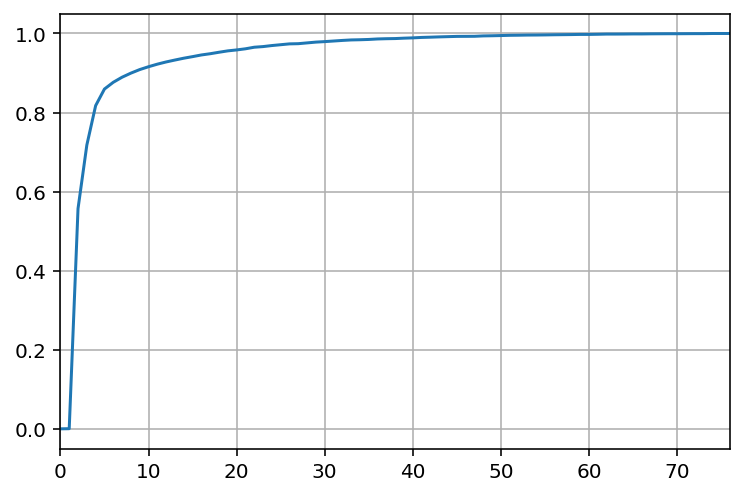

In [20]:
cdf = {i: (wrong.ratio <= i).sum() / len(wrong) for i in lims}
ax = pd.Series(cdf).plot()
ax.grid()

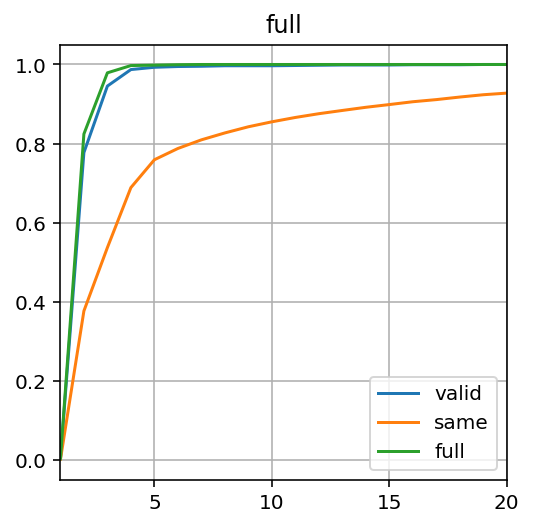

In [21]:
lims = range(int(wrong.ratio.max() + 1))

import matplotlib.pyplot as plt
w = 4
fig, ax = plt.subplots(figsize=(w, w))
for mode in ["valid", "same", "full"]:
    show = wrong[wrong["mode"] == mode]
    cdf = {i: (show.ratio <= i).sum() / len(show) for i in lims}
    ax = pd.Series(cdf).plot(ax=ax, label=mode)
ax.grid()
ax.legend(loc="best")
_ = ax.set_title(mode)
_ = ax.set_xlim(1, 20)